Now the model has been evaluated on test set. Retrain model on all data before predicting on live loans

In [7]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold
import lightgbm as lgb
from scipy.cluster import hierarchy as hc
import scipy
from scipy import stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
pd.set_option('display.max_columns', 50)

In [8]:
data_path = 'data/'

In [9]:
train_df = pd.read_pickle(data_path+'train_lgbm.pkl')
test_df = pd.read_pickle(data_path+'test_lgbm.pkl')

In [10]:
train_df = pd.concat([train_df,test_df],ignore_index=True)

In [11]:
with open('x_cols.pickle', 'rb') as f:
    x_cols = pickle.load(f)

In [12]:
# define a few helper functions we will use repeatedly
def train_model(params, train_df, kf,x_cols=x_cols,save_model=False):

    # save fold scores
    scores = []

    # for fold predictions
    train_df['pred_returns'] = 0

    # feature importance dfs
    importance = pd.DataFrame(x_cols,columns=['Feature'])
    importance['gain'] = 0
    importance['split'] = 0


    # 5 fold split
    
    i = 0
    for train_ind, val_ind in kf.split(train_df):

        # split data
        x_train = train_df.iloc[train_ind][x_cols]
        y_train = train_df.iloc[train_ind]['returns']

        x_val = train_df.iloc[val_ind][x_cols]
        y_val = train_df.iloc[val_ind]['returns']

        train_data = lgb.Dataset(x_train,label=y_train)
        val_data = lgb.Dataset(x_val, label=y_val)

        # train model
        lgb_model = lgb.train(params,
                              train_data,
                              num_boost_round=10000,
                              valid_sets = [train_data, val_data],
                              verbose_eval=100,
                              early_stopping_rounds = 100)

        # Out-of-fold train prediction
        train_preds = lgb_model.predict(x_val)
        train_df.loc[val_ind,'pred_returns'] = train_preds

        # save scores
        score = r2_score(y_val,lgb_model.predict(x_val))
        scores.append(score)

        print(score)

        # feature importances
        gain_sum = lgb_model.feature_importance(importance_type='gain').sum()
        
        importance['gain'] += lgb_model.feature_importance(importance_type='gain')/gain_sum
        importance[f'gain_{i}'] = lgb_model.feature_importance(importance_type='gain')/gain_sum
        
        importance['split'] += lgb_model.feature_importance(importance_type='split')/5
        importance[f'split_{i}'] = lgb_model.feature_importance(importance_type='split')
        # save model
        if save_model==True:
            lgb_model.save_model(f'models/model_{i}.txt')
        i += 1
        
    return train_df, importance, np.array(scores)

def conf_interval(train_df=train_df,return_thresh=0.07,N=100,conf=0.95):
    high_returns = train_df.loc[train_df['pred_returns']>=return_thresh]
    high_returns = high_returns['returns']
    mu = high_returns.mean()
    sigma = high_returns.std()
    return mu, stats.norm.interval(conf, loc=mu, scale=sigma/np.sqrt(N))

def plot_importance(importance,imp_type,max_features=None):
    temp = importance.sort_values(by=imp_type,ascending=True)
    if max_features:
        temp = temp[-max_features:]
    plt.title(f'Feature Importance by {imp_type}')
    plt.barh(temp['Feature'],temp[imp_type]);

In [13]:
# sort data by time
train_df = train_df.sort_values('issue_d')
train_df.reset_index(inplace=True,drop=True)

In [15]:
kf = KFold(n_splits=5, shuffle=False, random_state=11)

In [16]:
# retrain model with new features, also with some hyperparameter tuning
params = {'num_leaves': 16,
          'learning_rate':0.05,
          'metric': 'rmse'}
train_df, importance, scores = train_model(params, train_df, kf,x_cols=x_cols,save_model=True)

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.165845	valid_1's rmse: 0.148862
[200]	training's rmse: 0.165303	valid_1's rmse: 0.148674
[300]	training's rmse: 0.164882	valid_1's rmse: 0.148692
Early stopping, best iteration is:
[254]	training's rmse: 0.165074	valid_1's rmse: 0.148659
0.0027194789476845393
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.16393	valid_1's rmse: 0.156308
[200]	training's rmse: 0.163304	valid_1's rmse: 0.156158
[300]	training's rmse: 0.162859	valid_1's rmse: 0.15612
[400]	training's rmse: 0.162457	valid_1's rmse: 0.156073
[500]	training's rmse: 0.162096	valid_1's rmse: 0.156066
[600]	training's rmse: 0.161767	valid_1's rmse: 0.15607
Early stopping, best iteration is:
[546]	training's rmse: 0.161944	valid_1's rmse: 0.156064
0.01296094256240321
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.162584	valid_1's rmse: 0.161614
[200]	training's r

In [17]:
scores.mean()

0.014984149115780433

In [18]:
conf_interval(train_df=train_df,return_thresh=0.07,N=100,conf=0.95)

(0.081333053936697, (0.04979724516821323, 0.11286886270518076))

Next plot loan performance on models predicted returns vs actuals

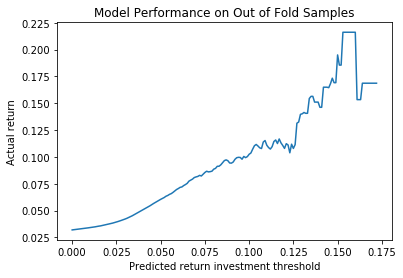

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

returns = []
# for each investment threshold
for t in np.arange(0,0.5, 0.001):
    
    # calculate average returns
    av_return = train_df.loc[train_df['pred_returns']>=t, 'returns'].mean()
    
    # also store how many potential loans there are to invest
    total_loans = len(train_df.loc[train_df['pred_returns']>=t, 'total_pymnt'])
    returns.append((av_return, t, total_loans))

plt.figure()
plt.plot([x[1] for x in returns], [x[0] for x in returns])
plt.title('Model Performance on Out of Fold Samples')
plt.xlabel('Predicted return investment threshold')
plt.ylabel('Actual return');

In [21]:
# train set average returns
train_df.returns.mean()

0.025902803011634657

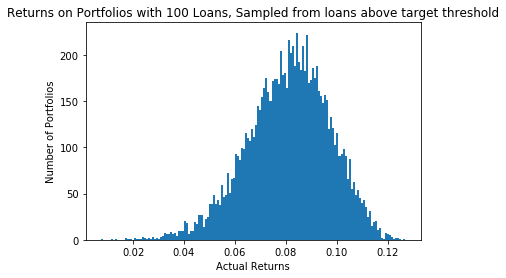

In [22]:
# plot distribution of sampled portfolios
high_returns = train_df.loc[train_df['pred_returns']>=0.07]
high_returns = high_returns['returns']

from scipy import stats
high_returns.mean()

returns = []
for i in range(10000):
    returns.append(np.random.choice(high_returns,size=100,replace=True).mean())
plt.hist(returns,bins=150)
plt.title('Returns on Portfolios with 100 Loans, Sampled from loans above target threshold')
plt.xlabel('Actual Returns')
plt.ylabel('Number of Portfolios');

In [23]:
# av returns, confidence interval, percantage of loans available to invest in
conf_interval(train_df,return_thresh=0.07), len(train_df.loc[train_df['pred_returns']>=0.07])/len(train_df)

((0.081333053936697, (0.04979724516821323, 0.11286886270518076)),
 0.006373833101377896)

In [24]:
conf_interval(train_df,return_thresh=0.075), len(train_df.loc[train_df['pred_returns']>=0.075])/len(train_df)

((0.08546082857469273, (0.052833270542411714, 0.11808838660697374)),
 0.003718263089785938)

In [25]:
conf_interval(train_df,return_thresh=0.08), len(train_df.loc[train_df['pred_returns']>=0.08])/len(train_df)

((0.08856740973298494, (0.05486191703467112, 0.12227290243129875)),
 0.0022683962752258805)